In [1]:
from sklearn.dummy import DummyClassifier
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from typing import Type
from torch.optim import lr_scheduler
from torch.nn import Module,Linear,Sequential,ReLU,ELU,Dropout,BatchNorm1d,Flatten,CrossEntropyLoss,Conv2d,MaxPool2d
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import os
import sys
import random
import copy
import time
import shutil
import pickle
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
from sklearn import metrics
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from pandas import DataFrame
import seaborn as sn
import numpy as np
import PIL
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
from ipynb.fs.full._3_prepare_tracked_datasets import Char,Poly,Point
from ipynb.fs.full._2_emnist_analyze import LeNet,MyResNet,BasicBlock,Trainer
#,Trainer

0
None
0
None
0


/opt/jupyter_venvs/mipt_venv/lib64/python3.11/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/opt/jupyter_venvs/mipt_venv/lib64/python3.11/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/opt/jupyter_venvs/mipt_venv/lib64/python3.11/site-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/opt/jupyter_venvs/mipt_venv/lib64/python3.11/site-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/home/d.yacenko/work/Dissertation/_2_emnist_analyze.ipynb:231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is p

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [4]:
BATCH_SIZE=50
EPOCHS=10
CURRENT_FOLDER="./"
DATASET_VARIANT="byclass"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
class CustomUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
       if name == 'Char' and __name__ != "__main__":
            from Prepare_Dataset import Char
            return Char
       if name == 'Poly' and __name__ != "__main__":
            from Prepare_Dataset import Poly
            return Poly
       if name == 'Point' and __name__ != "__main__":
            from Prepare_Dataset import Point
            return Point
       return super().find_class(module, name)

class CustomPickler(pickle.Pickler):
    def find_class(self, module, name):
       if name == 'Char' and __name__ != "__main__":
            from Prepare_Dataset import Char
            return Char
       if name == 'Poly' and __name__ != "__main__":
            from Prepare_Dataset import Poly
            return Poly
       if name == 'Point' and __name__ != "__main__":
            from Prepare_Dataset import Point
            return Point
       return super().find_class(module, name)

load dataset

In [6]:
f_train_dict= open(os.path.join(CURRENT_FOLDER,'train_dict_RUS.p'), 'rb')
f_test_dict= open(os.path.join(CURRENT_FOLDER,'test_dict_RUS.p'), 'rb')
TRAIN_DICT = CustomUnpickler(f_train_dict).load()
TEST_DICT = CustomUnpickler(f_test_dict).load()
f_train_dict.close()
f_test_dict.close()

In [7]:
# print(TRAIN_DICT)
# print(TEST_DICT)
CHAR_LIST=list(TRAIN_DICT.keys())
CHAR_LIST.sort()
print("Классов: {}".format(len(list(TRAIN_DICT.keys()))))
print(list(TRAIN_DICT.keys()).sort())
all_size=0
for key in TRAIN_DICT.keys():
  all_size+=len(TRAIN_DICT[key])

Классов: 76
None


In [8]:
all_size

2245

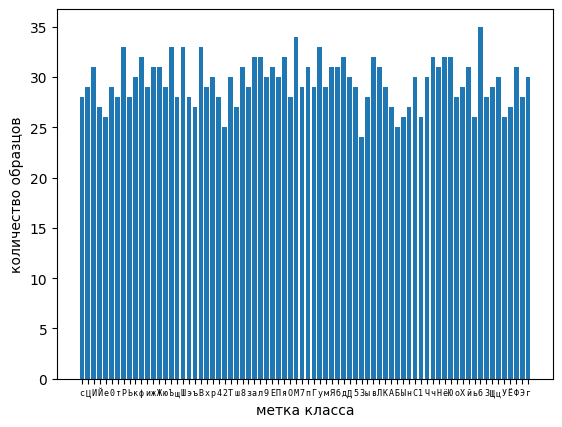

In [9]:
plt.bar( TRAIN_DICT.keys(),[len(TRAIN_DICT[key]) for key in TRAIN_DICT.keys()])
plt.xticks( fontsize=6, fontname='monospace')

plt.xlabel("метка класса")
plt.ylabel("количество образцов")
plt.savefig("images/rus_dataset.png",  bbox_inches='tight', pad_inches=0)

In [10]:
class ImageDataset(Dataset):

    def __init__(self, data, transform=None):
        str="0123456789АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюя"
        # str="0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
        self.data=np.array([])
        for key in data.keys():
            for ch in data[key]:
                if key in str:
                    self.data=np.append(self.data,[ch])              
        self.classes=list(str)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img=self.data[idx].singleImage()
        array = np.array(img, dtype=np.uint8)
        img = Image.fromarray(array)
        if self.transform:
            img = self.transform(img)
        class_num=self.classes.index(self.data[idx].name)
        return img,class_num

In [11]:
image_datasets = {"train": ImageDataset(TRAIN_DICT,transform=transforms.Compose([lambda img: torchvision.transforms.functional.rotate(img, -90),
                                                                    transforms.RandomRotation(degrees=(-90,-90)),
                                                                    transforms.RandomHorizontalFlip(p=1),
                                                                     transforms.Resize(32),            
                                                                     # transforms.Pad(2),                                                   
                                                                    transforms.ToTensor()])),
                 "val":ImageDataset(TEST_DICT,transform=transforms.Compose([lambda img: torchvision.transforms.functional.rotate(img, -90),
                                                                    transforms.RandomRotation(degrees=(-90,-90)),
                                                                    transforms.RandomHorizontalFlip(p=1),
                                                                    transforms.Resize(32),        
                                                                     # transforms.Pad(2),                                                   
                                                                    transforms.ToTensor()]))}
dataloaders = {"train": torch.utils.data.DataLoader(image_datasets["train"], batch_size=BATCH_SIZE,shuffle=True),
               "val": torch.utils.data.DataLoader(image_datasets["val"], batch_size=BATCH_SIZE,shuffle=True),
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
classes_names = {x: image_datasets[x].classes for x in ['train', 'val']}

torch.Size([3, 240, 274])


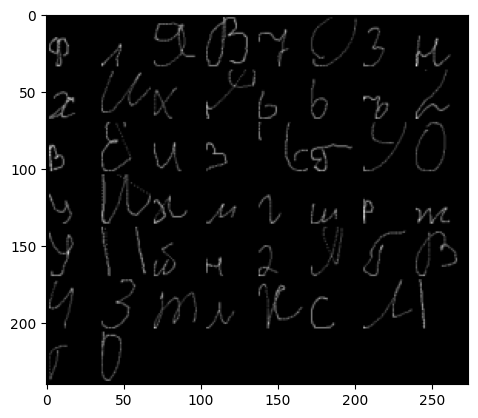

    Ф     л     Я     в     7     О     З     н     х     Щ     Х     А     ь     Ь     ъ     2     В     Ё     и     3     Ъ     Г     9     0     У     И     Х     м     г     ш     р     ж     У     П     й     н     2     П     Г     В     Ч     З     т     л     х     с     Л     Г     Т     0


In [12]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.savefig("images/rus_images.png",  bbox_inches='tight', pad_inches=0)
    plt.show()

# Get a batch of training data
image, label = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(image)
print(out.shape)
imshow(torchvision.utils.make_grid(out))
str=' '.join('%5s' % image_datasets['val'].classes[label[j]] for j in range(BATCH_SIZE))
print(str)
with open('images/rus_images_lbl.txt', 'w') as f:
    f.write(str)

create LeNet-5 model

In [13]:
tr=Trainer()

In [14]:
net = LeNet(num_classes=len(image_datasets["train"].classes)).to(device)


train

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=17, gamma=0.1)

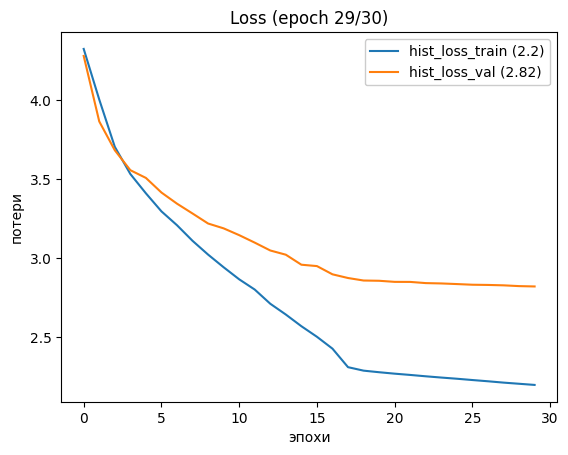

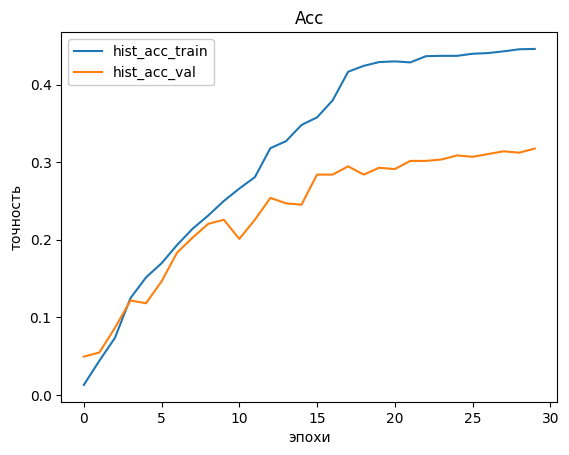

Train time:42.72126054763794
Best acc:0.31746031746031744


In [16]:
if __name__ == "__main__":
    start = time.time()
    model,acc=tr.train_model(net, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=30, net_name="lenet_rus")
    end = time.time()
    print("Train time:{}".format(end - start))
    print("Best acc:{}".format(acc))

transfer learning 

In [17]:
net = LeNet(num_classes=62).to(device)
DATASET_VARIANT= "byclass" #  "balanced" #  
i=0
net.load_state_dict(torch.load("models/emnist_lenet_"+DATASET_VARIANT+".pt"))
# for param in net.parameters():
#     param.requires_grad = False
net.fc3 = nn.Linear(net.fc3.in_features, len(image_datasets["train"].classes))
net=net.to(device)

/tmp/ipykernel_47918/1097774605.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("models/emnist_lenet_"+DATASET_VARIANT+".pt"))


In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=17, gamma=0.1)

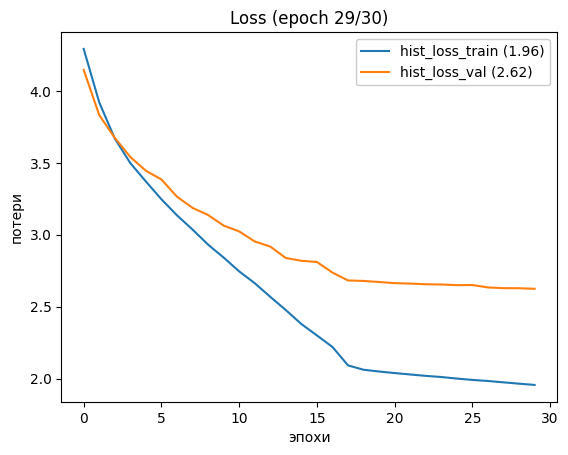

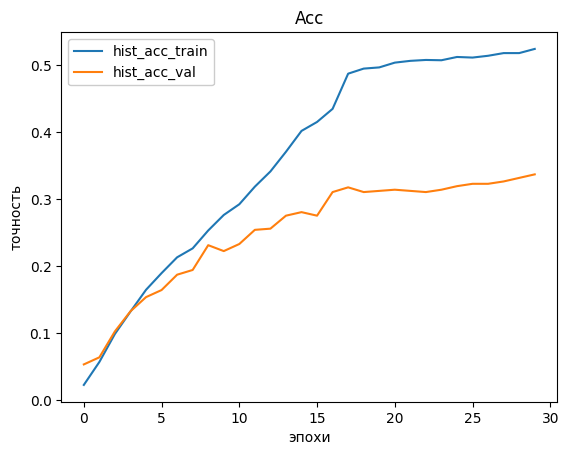

Train time:41.73405861854553
Best acc:0.3368606701940035


In [19]:
if __name__ == "__main__":
    start = time.time()
    model,acc=tr.train_model(net, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=30, net_name="lenet_rus_transfer_learning")
    end = time.time()
    print("Train time:{}".format(end - start))
    print("Best acc:{}".format(acc))

analyze

In [20]:
_preds=np.array([])
_targets=np.array([])
for inputs, labels in dataloaders['val']:    # Iterate over data.
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    _targets=np.append(_targets, labels.detach().cpu().numpy())
    _preds=np.append(_preds,preds.detach().cpu().numpy())


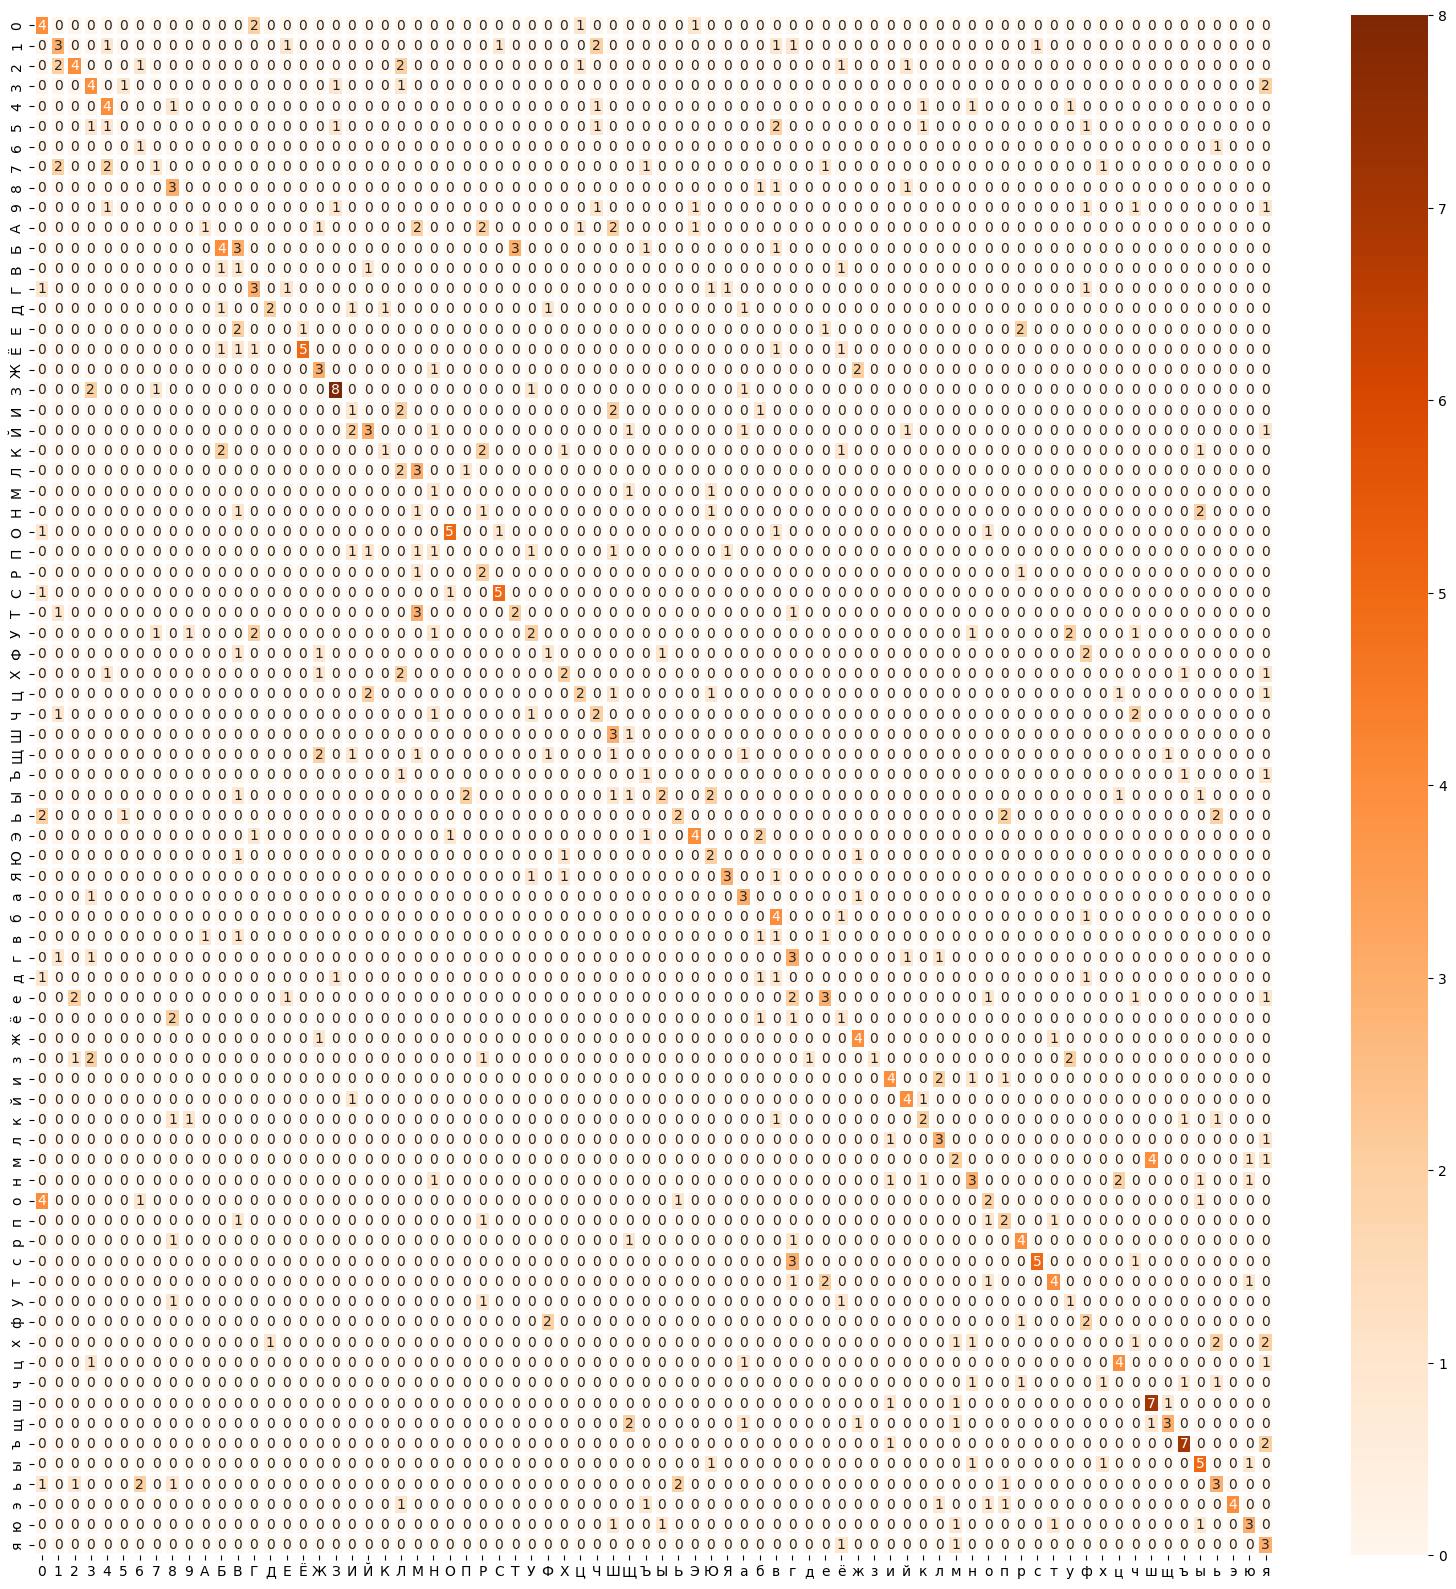

In [21]:
cm=metrics.confusion_matrix(_targets,_preds)
df_cm = DataFrame(cm, index=classes_names["val"], columns=classes_names["val"])
from pandas import DataFrame
import seaborn as sn
plt.subplots(figsize=(20,20))
sn.heatmap(df_cm,annot=True, fmt="d",linewidths=1.5,cmap="Oranges",)
plt.savefig("images/rus_confusion_matrix.png",  bbox_inches='tight', pad_inches=0)
plt.show()